# Project: food.ai
This is a Machine Learning Pipeline which classifies 101 different images of food dataset from Kaggel https://www.kaggle.com/datasets/dansbecker/food-101

Overview of this notebook:
1. Using TensorFlow Datasets to download and explore whole data of Food101
2. Creating a preprocessing function for our data
3. Batching and preparing datasets for modelling (making them run fast)
4. Setting up mixed precision training (use of both 16 and 32-bit float-point type for faster model training)
5. Building and training a **Feature Extraction Transfer Learning** model
6. Fine-tuning the feature extraction model to beat the DeepFood Paper
7. Evaluating the model results by making and plotting Predictions

> **Note:** Among NVIDIA GPUs, those with compute capability 7.0 or higher will see the greatest performance benefit from **mixed precision** because they have special hardware units, called Tensor Cores, to accelerate float16 matrix multiplications and convolutions. Source: https://www.tensorflow.org/guide/mixed_precision

> In my case, I currently have access to NVIDIA GeForce RTX 2060/GeForce GTX 1650 Ti, which has compute capability of 7.5. Source: https://developer.nvidia.com/cuda-gpus

In [31]:
# GPU Check
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2060 (UUID: GPU-694ef843-97f6-b3eb-bb69-5539274f049e)


In [41]:
# import required libraries
import tensorflow as tf
import matplotlib.pyplot as plt

## Get helper functions
We've written a number of helper functions that are frequently utilized in our scripts. We can then import that script and load every function from it. My github has that script available for us.

In [4]:
# Download helper functions script
#!wget https://raw.githubusercontent.com/rajiblama743/Extra/refs/heads/main/helper_functions.py

In [10]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFLow Datasets to download Data 
TensorFlow Datasets is a collection of datasets ready to use, with TensorFlow or other Python ML frameworks...

Food101 happens to be one of them. Hurray...

Source: https://www.tensorflow.org/datasets/catalog/overview#all_datasets

In [13]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [17]:
# Confirming if our dataset is in TensorFlow Datasets
datasets_list = tfds.list_builders() # gets all available datasets in tfds

print("Is our target dataset in the list of tfds datasets?")
if "food101" in datasets_list:
    print("-> There is. Yeah!")
else:
    print("-> Noooooo...")

Is our target dataset in the list of tfds datasets?
-> There is. Yeah!


In [24]:
# Load in the data
(train_data, test_data), ds_ifo = tfds.load(name="food101",
                                           split=["train", "validation"],
                                           shuffle_files=True,
                                           as_supervised=True, # data gets returned in tupl format (data, label),
                                           with_info=True) # this loads the meta data along with tensors(image data) and store it in ds_info

## Exploring the food101 data from TensorFLow Datasets

To become one with our data, we want to find:
1. class names
2. the shapes of our input data (image tensors)
3. the datatype of our input data
4. what the labels look like (e.g. are they one-hot encoded or ar they label encoded)
5. do the labels match up with the class names?

In [19]:
# Features of Food101 from tfds
ds_ifo.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [21]:
# Get the class names
class_names = ds_ifo.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [48]:
# Take one sample of train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [49]:
# Output info about our traininig sample
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target class from food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target class from food101 (tensor form): 81
    Class name (str form): ramen
    


2025-01-13 00:09:26.937127: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [45]:
# What does our image tensor from tfds's food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 28,  31,  50],
        [ 27,  30,  49],
        [ 21,  23,  44],
        ...,
        [ 17,  28,  60],
        [ 20,  30,  65],
        [ 28,  38,  73]],

       [[ 11,  14,  33],
        [ 23,  26,  45],
        [ 24,  26,  47],
        ...,
        [ 39,  50,  82],
        [ 33,  44,  76],
        [ 19,  30,  62]],

       [[ 16,  17,  37],
        [ 23,  24,  44],
        [ 19,  20,  40],
        ...,
        [ 45,  56,  86],
        [ 39,  50,  80],
        [ 36,  47,  77]],

       ...,

       [[148,  94, 117],
        [153,  99, 122],
        [153, 102, 121],
        ...,
        [ 94, 128, 166],
        [ 96, 130, 168],
        [ 96, 131, 169]],

       [[143,  89, 112],
        [151,  97, 120],
        [153, 102, 121],
        ...,
        [102, 134, 173],
        [103, 135, 174],
        [101, 135, 173]],

       [[145,  91, 114],
        [154, 100, 123],
        [158, 107, 126],
        ...,
        [105, 137, 17

In [46]:
# What are the min and max values of our image tensor?

# Usually the values of the image are between 0 and 255
tf.reduce_min(image).numpy(), tf.reduce_max(image).numpy()

(np.uint8(0), np.uint8(255))

### Plot an image from TensorFlow Datasets

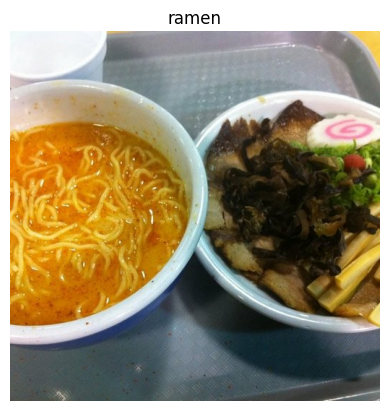

In [52]:
# Plot an image tensor
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);